# Kategorinen data ja puuttuvien arvojen käsittely

In [1]:
import pandas as pd 
import numpy as np 

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import os 

In [2]:
# luetaan data ja tallennetaan se csv-tiedostoon
if os.path.exists('abnd_listings.csv'):
    df = pd.read_csv('abnd_listings.csv')
else:
    df = pd.read_csv('https://raw.githubusercontent.com/InfoTUNI/joda2022/master/koodiesimerkit/data.csv')
    df.to_csv('abnd_listings.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16313 entries, 0 to 16312
Data columns (total 98 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0.1                      16313 non-null  int64  
 1   Unnamed: 0                        16313 non-null  int64  
 2   id                                16313 non-null  int64  
 3   listing_url                       16313 non-null  object 
 4   scrape_id                         16313 non-null  int64  
 5   last_scraped                      16313 non-null  object 
 6   name                              16302 non-null  object 
 7   summary                           15860 non-null  object 
 8   space                             11798 non-null  object 
 9   description                       16305 non-null  object 
 10  experiences_offered               16313 non-null  object 
 11  neighborhood_overview             10343 non-null  object 
 12  note

In [3]:
df_no_missing = df[['host_response_time', 'host_response_rate', 'review_scores_rating']].copy()

print(df_no_missing.head())
print(df_no_missing.host_response_time.unique())

  host_response_time host_response_rate  review_scores_rating
0       within a day                60%                  89.0
1     within an hour               100%                  91.0
2     within an hour               100%                  79.0
3     within an hour               100%                  90.0
4     within an hour               100%                  80.0
['within a day' 'within an hour' 'within a few hours' nan
 'a few days or more']


In [4]:
df_no_missing.host_response_rate = df_no_missing.host_response_rate.str.strip('%')
df_no_missing.host_response_rate = pd.to_numeric(df_no_missing.host_response_rate)

print(df_no_missing.info, '\n')
print(df_no_missing.dtypes, '\n')
print(df_no_missing.head(), '\n')

null_counts = df_no_missing.isnull().sum()
print(f"Null values count: \n {null_counts}")

<bound method DataFrame.info of        host_response_time  host_response_rate  review_scores_rating
0            within a day                60.0                  89.0
1          within an hour               100.0                  91.0
2          within an hour               100.0                  79.0
3          within an hour               100.0                  90.0
4          within an hour               100.0                  80.0
...                   ...                 ...                   ...
16308  within a few hours               100.0                   NaN
16309  within a few hours                70.0                   NaN
16310      within an hour               100.0                   NaN
16311      within an hour                96.0                   NaN
16312      within an hour                91.0                   NaN

[16313 rows x 3 columns]> 

host_response_time       object
host_response_rate      float64
review_scores_rating    float64
dtype: object 

  host_resp

In [5]:
# Pudotetaan rivit, joissa on puuttuvia arvoja
df_no_missing = df_no_missing.dropna()
df_no_missing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11855 entries, 0 to 16218
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_response_time    11855 non-null  object 
 1   host_response_rate    11855 non-null  float64
 2   review_scores_rating  11855 non-null  float64
dtypes: float64(2), object(1)
memory usage: 370.5+ KB


In [6]:
# Kategorisoidaan host_response_time -sarake
le = preprocessing.LabelEncoder()
arr = le.fit_transform(df_no_missing.host_response_time)
df_no_missing.host_response_time = arr 

In [7]:
print(arr)
df_no_missing.head()

[1 3 3 ... 3 3 3]


,host_response_time,host_response_rate,review_scores_rating
0,1,60.0,89.0
1,3,100.0,91.0
2,3,100.0,79.0
3,3,100.0,90.0
4,3,100.0,80.0


In [8]:
# Käytetään lineaarista mallia, joka ennustaa review_scores_rating -sarakeen arvoja.
lr = linear_model.LinearRegression()
y = df_no_missing.review_scores_rating
X = df_no_missing.drop(columns='review_scores_rating')


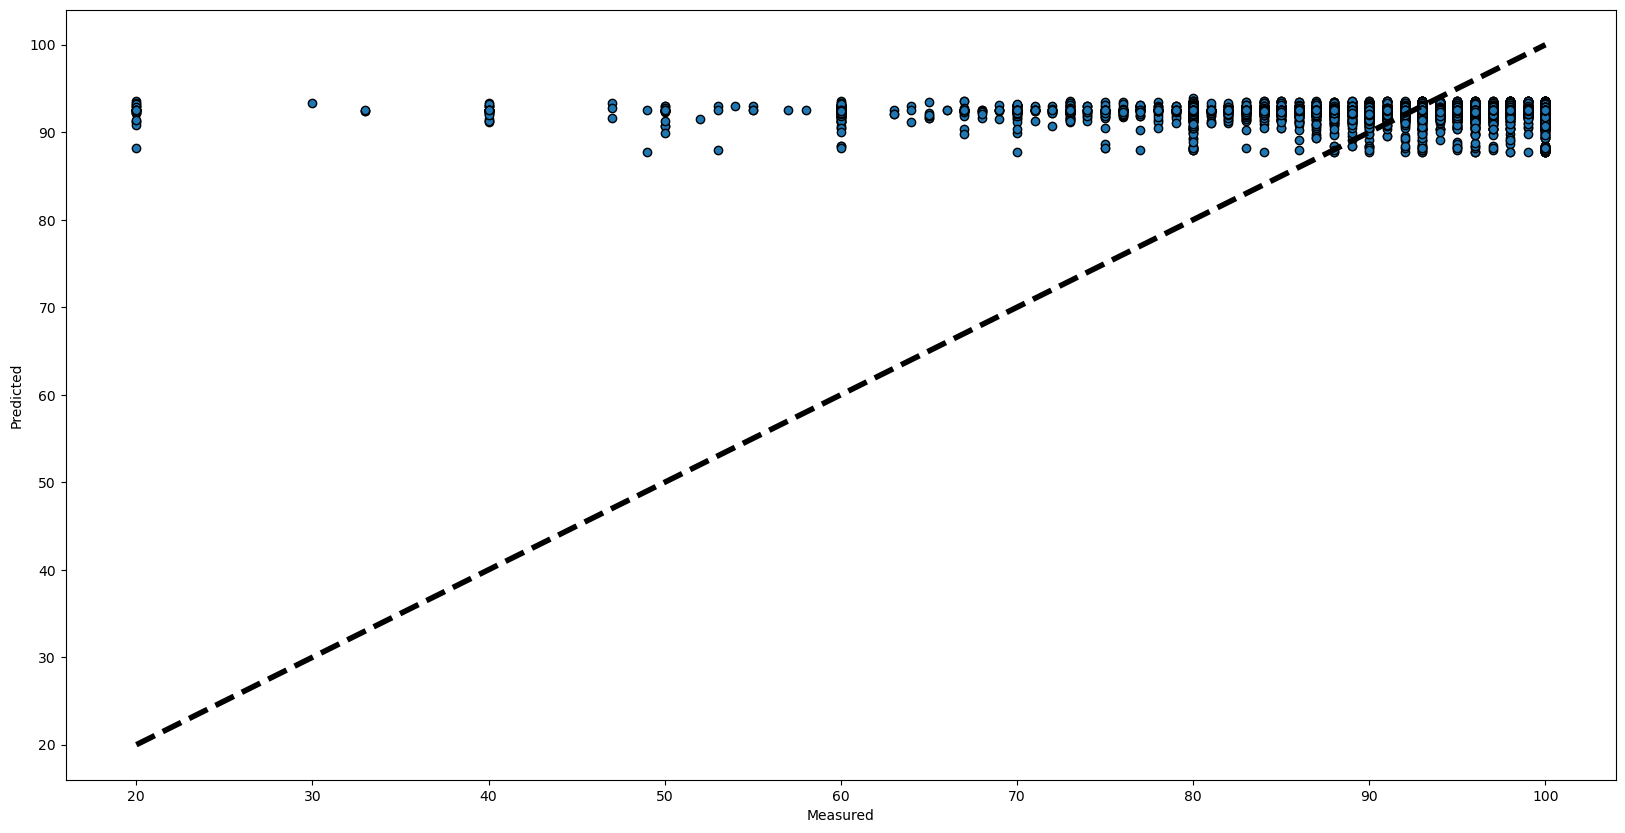

In [9]:
predictions = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots(figsize = (20,10))

ax.scatter(y, predictions, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [10]:
print(df_no_missing.corr())


                      host_response_time  host_response_rate  \
host_response_time              1.000000            0.586101   
host_response_rate              0.586101            1.000000   
review_scores_rating            0.018660            0.066256   

                      review_scores_rating  
host_response_time                0.018660  
host_response_rate                0.066256  
review_scores_rating              1.000000  


In [11]:
mse = mean_squared_error(predictions, y)
mae = mean_absolute_error(predictions, y)
print(f"Mean squared error: {mse:.2f}\nMean absolute error: {mae:.2f}")

Mean squared error: 72.83
Mean absolute error: 5.72


# Toinen lähestymistapa - Täytetään tyhjät arvot mediaanilla 

In [12]:
df_imp = df[['review_scores_accuracy','review_scores_cleanliness',
         'review_scores_checkin','review_scores_communication',
         'review_scores_location','review_scores_value',
         'review_scores_rating']].copy()

print(df_imp.isnull().sum())


review_scores_accuracy         3208
review_scores_cleanliness      3202
review_scores_checkin          3224
review_scores_communication    3209
review_scores_location         3230
review_scores_value            3231
review_scores_rating           3195
dtype: int64


In [13]:
# Tarkastellaan otettujen muuttujien mediaaneja
df_imp.median()

review_scores_accuracy         10.0
review_scores_cleanliness      10.0
review_scores_checkin          10.0
review_scores_communication    10.0
review_scores_location         10.0
review_scores_value             9.0
review_scores_rating           95.0
dtype: float64

In [14]:
# Lisätään tyhjiin arvioihin kyseiisten sarakkeiden mediaaniarvot
df_imp = df_imp.fillna(df_imp.median())
print(df_imp.isnull().sum())

review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
review_scores_rating           0
dtype: int64


# Ennustetaan lineaarisella mallilla arvostelut jossa tyhjät arvot korvattu kyseisen sarakkeen mediaanilla

In [15]:
# Käytetään lineaarista mallia, joka ennustaa review_scores_rating -sarakeen arvoja.
lr = linear_model.LinearRegression()

y = df_imp.review_scores_rating
X = df_imp.drop(columns='review_scores_rating')

# Erotetaan testi ja opetusdata toisistaan
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

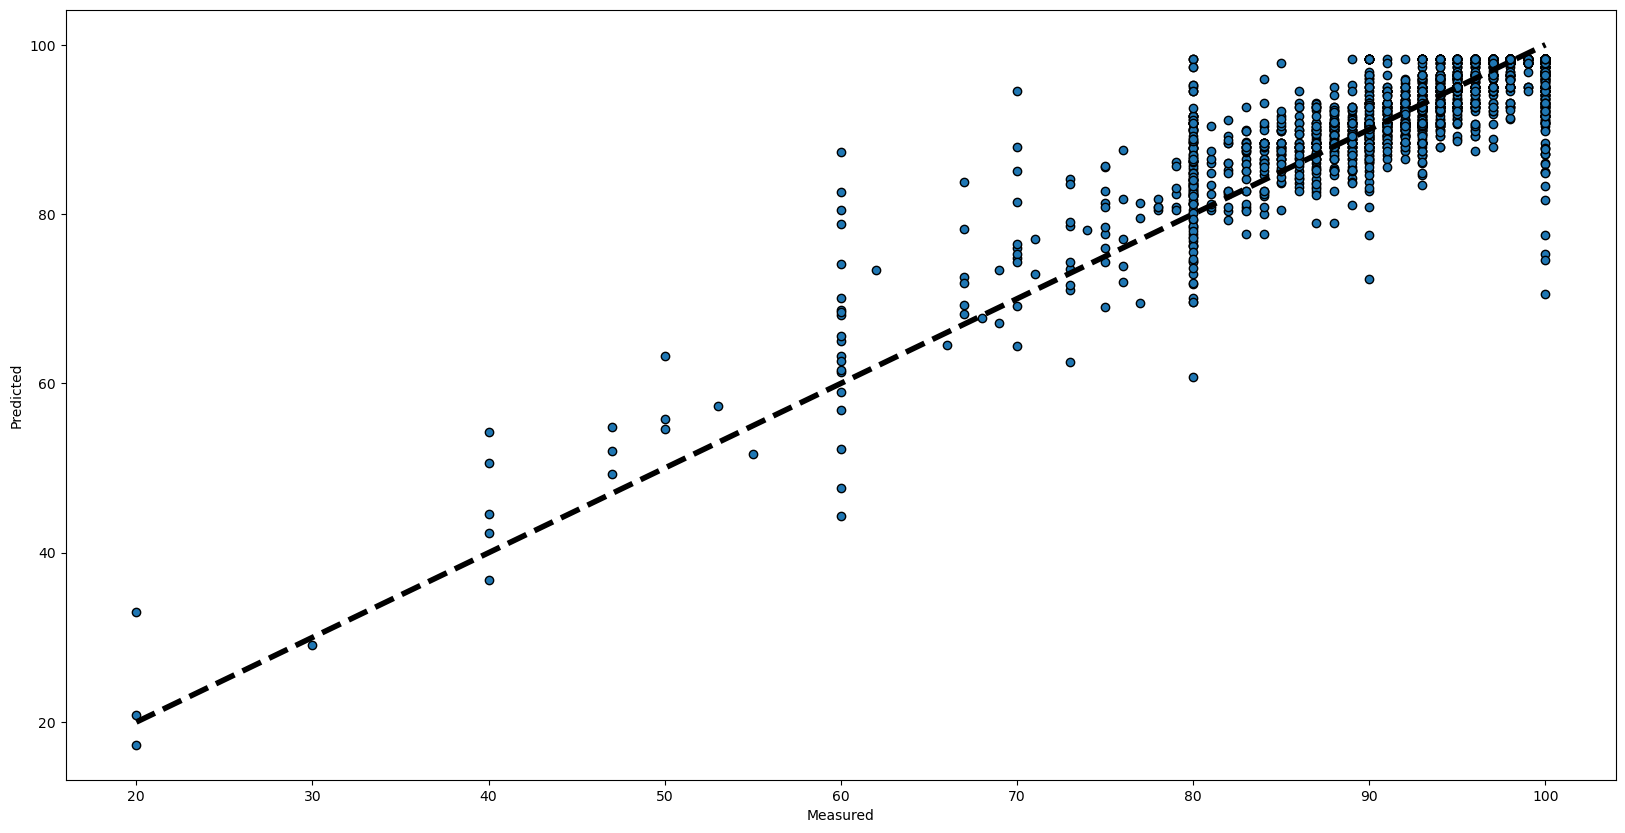

In [16]:
fig, ax = plt.subplots(figsize = (20,10))
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [17]:
print(df_imp.corr()['review_scores_rating'])

review_scores_accuracy         0.759918
review_scores_cleanliness      0.702815
review_scores_checkin          0.632046
review_scores_communication    0.663075
review_scores_location         0.433515
review_scores_value            0.766700
review_scores_rating           1.000000
Name: review_scores_rating, dtype: float64


In [18]:
# Tarkastellaan lineaarisen mallin virheitä 

mse = mean_squared_error(predictions, y_test)
mae = mean_absolute_error(predictions, y_test)

# Pidetään tällä yllä eri mallien suorituskykyä
models_performance = pd.DataFrame({'Model Name': ['Linear Regression'], 'MSE': [mse], 'MAE': [mae]})


# Käytetään satunnaista päätöspuumetsää ja optimoidaan hyperparametrit satunnaisella haulla 

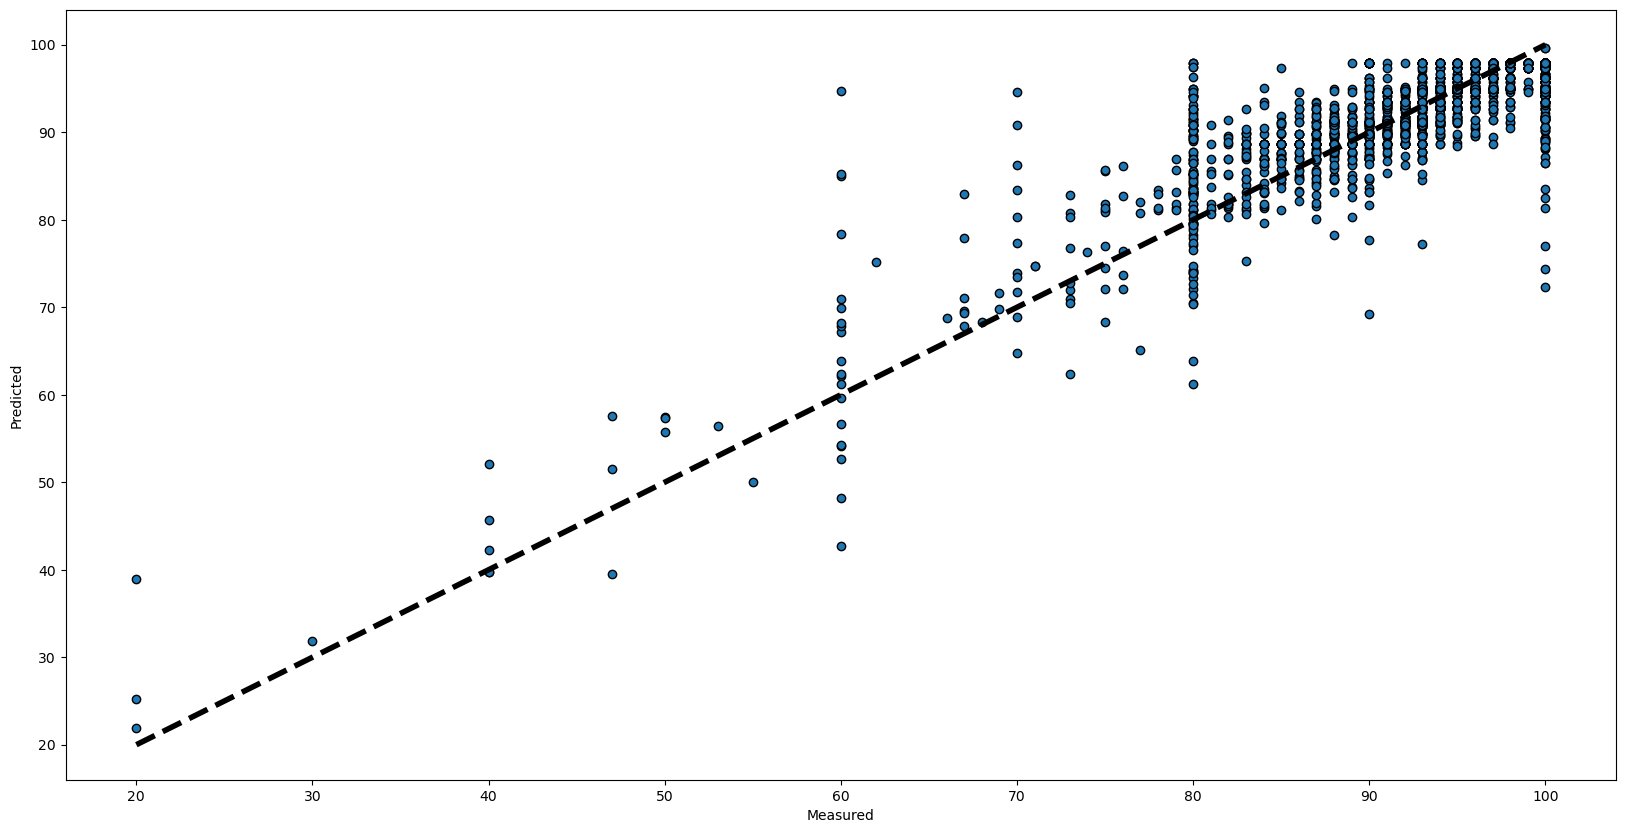

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

# Määritellään hyperparametrien etsintäavaruus
param_space = {
    'n_estimators': np.arange(1, 500, 10),
    'max_depth': np.arange(3, 11),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 6),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Haetaan parhaat hyperparametrit
random_search = RandomizedSearchCV(
estimator = rf,
param_distributions = param_space,
cv = 5,
n_jobs= -2,
n_iter = 1000,
verbose = 0
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Käytetään parhaita hyperparametrejä
predictions = best_model.predict(X_test)

# Tarkastellaan mallin toimivuutta
fig, ax = plt.subplots(figsize = (20,10))
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

mse = mean_squared_error(predictions, y_test)
mae = mean_absolute_error(predictions, y_test)

# Tallennetaan mallin suorituskyky
models_performance = pd.concat([models_performance, pd.DataFrame({'Model Name': ['RandomForestRegressor'], 'MSE': [mse], 'MAE': [mae]})], ignore_index=True)


# Testataan XGBoost mallia ja etsitään sillekin hyperparametrit 

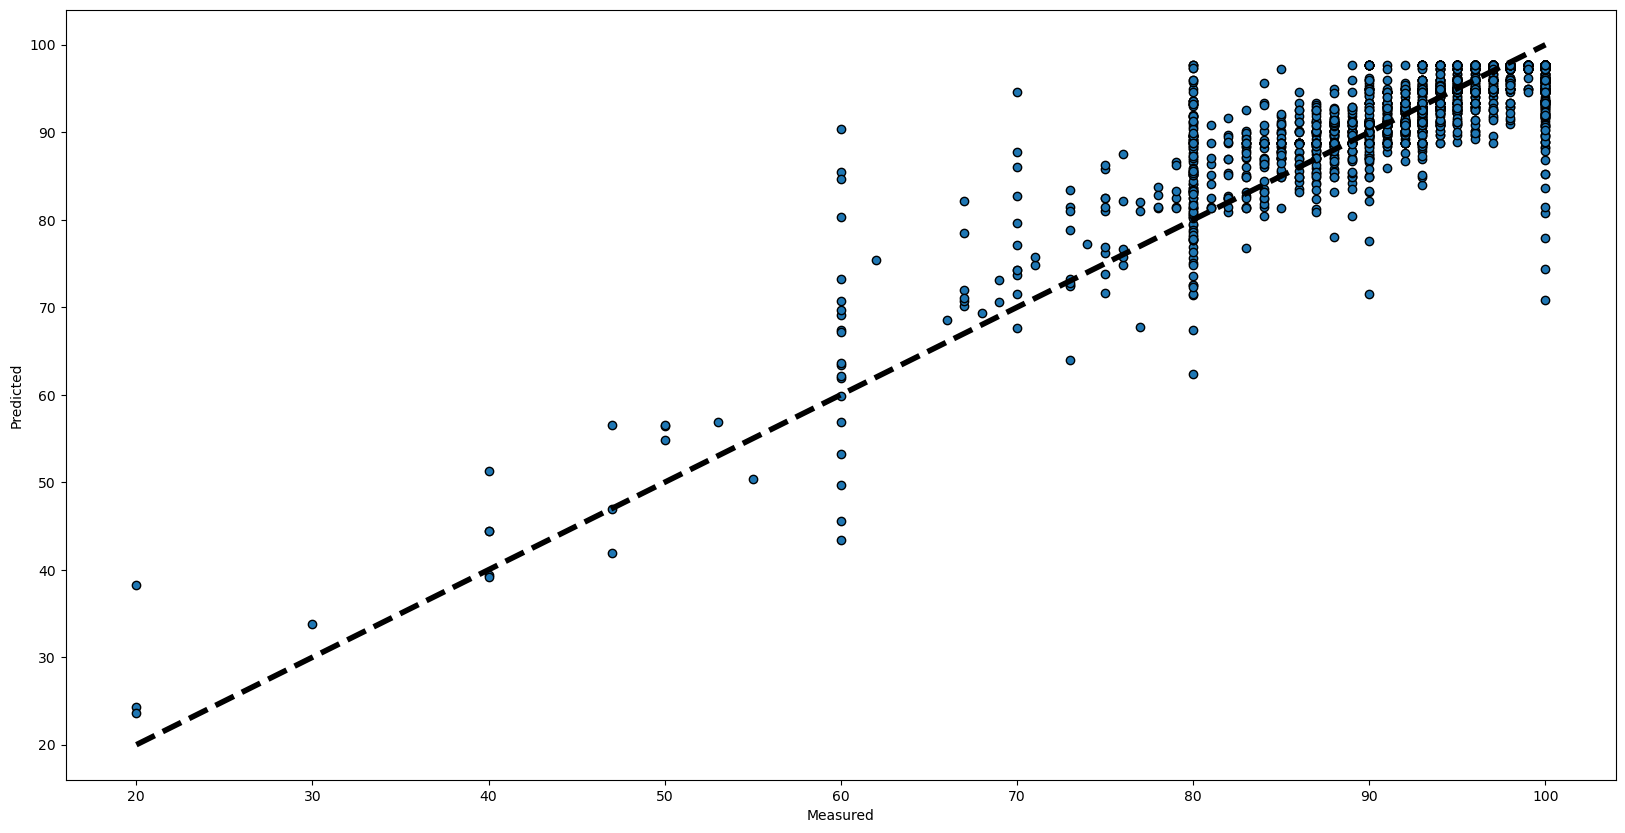

In [20]:
import xgboost

# Käyetään xgboost -mallia MSE objektiivilla
xgb = xgboost.XGBRegressor(objective ='reg:squarederror')

param_space = {
    'n_estimators': np.arange(1, 500, 10),
    'max_depth': np.arange(3, 11),
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2] 
}

random_search = RandomizedSearchCV(
estimator = xgb,
param_distributions = param_space,
cv = 5,
n_jobs= -2,
n_iter = 1000,
verbose = 0
)


random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Käytetään parhaita hyperparametrejä
predictions = best_model.predict(X_test)

# Tarkastellaan mallin toimivuutta
fig, ax = plt.subplots(figsize = (20,10))
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

mse = mean_squared_error(predictions, y_test)
mae = mean_absolute_error(predictions, y_test)

# Tallennetaan saadut arvot
models_performance = pd.concat([models_performance, pd.DataFrame({'Model Name': ['XGBoost'], 'MSE': [mse], 'MAE': [mae]})], ignore_index=True)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Jaa data koulutus- ja testijoukkoihin


# Standardoi ominaisuudet
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Muodostetaan neuroverkko 
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1],))) 
model.add(Dense(64, activation='relu'))  
model.add(Dense(16, activation='relu'))  
model.add(Dense(1, activation='linear'))  

# Kompiloi malli
model.compile(loss='mean_squared_error', optimizer='Adam')
model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=2)

predictions = model.predict(X_test_scaled)
mse = mean_squared_error(predictions, y_test)
mae = mean_absolute_error(predictions, y_test)

# Tallennetaan saadut arvot
models_performance = pd.concat([models_performance, pd.DataFrame({'Model Name': ['Neural Network'], 'MSE': [mse], 'MAE': [mae]})], ignore_index=True)





2024-03-10 10:49:24.566556: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 10:49:25.387711: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/100


2024-03-10 10:49:25.933471: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 10:49:26.143295: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


164/164 - 1s - 5ms/step - loss: 6841.7324 - val_loss: 3183.8330
Epoch 2/100
164/164 - 0s - 1ms/step - loss: 1286.5962 - val_loss: 677.2505
Epoch 3/100
164/164 - 0s - 1ms/step - loss: 519.4279 - val_loss: 374.0152
Epoch 4/100
164/164 - 0s - 1ms/step - loss: 300.5278 - val_loss: 239.1607
Epoch 5/100
164/164 - 0s - 1ms/step - loss: 192.1292 - val_loss: 171.1738
Epoch 6/100
164/164 - 0s - 1ms/step - loss: 136.3697 - val_loss: 130.6044
Epoch 7/100
164/164 - 0s - 1ms/step - loss: 102.2072 - val_loss: 104.0724
Epoch 8/100
164/164 - 0s - 1ms/step - loss: 80.6328 - val_loss: 86.0115
Epoch 9/100
164/164 - 0s - 1ms/step - loss: 65.1649 - val_loss: 71.6321
Epoch 10/100
164/164 - 0s - 1ms/step - loss: 52.1035 - val_loss: 58.5628
Epoch 11/100
164/164 - 0s - 1ms/step - loss: 41.4955 - val_loss: 48.2679
Epoch 12/100
164/164 - 0s - 1ms/step - loss: 34.5028 - val_loss: 42.0660
Epoch 13/100
164/164 - 0s - 1ms/step - loss: 29.7226 - val_loss: 37.9758
Epoch 14/100
164/164 - 0s - 1ms/step - loss: 26.5005 - 

# Otetaan neuroverkosta viimeinen kerros pois ja testataan tällä XGBoostia näin tulleihin ominaisuusvektoriin ja toteutetaan hypeparametrien satunnaishaku

408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


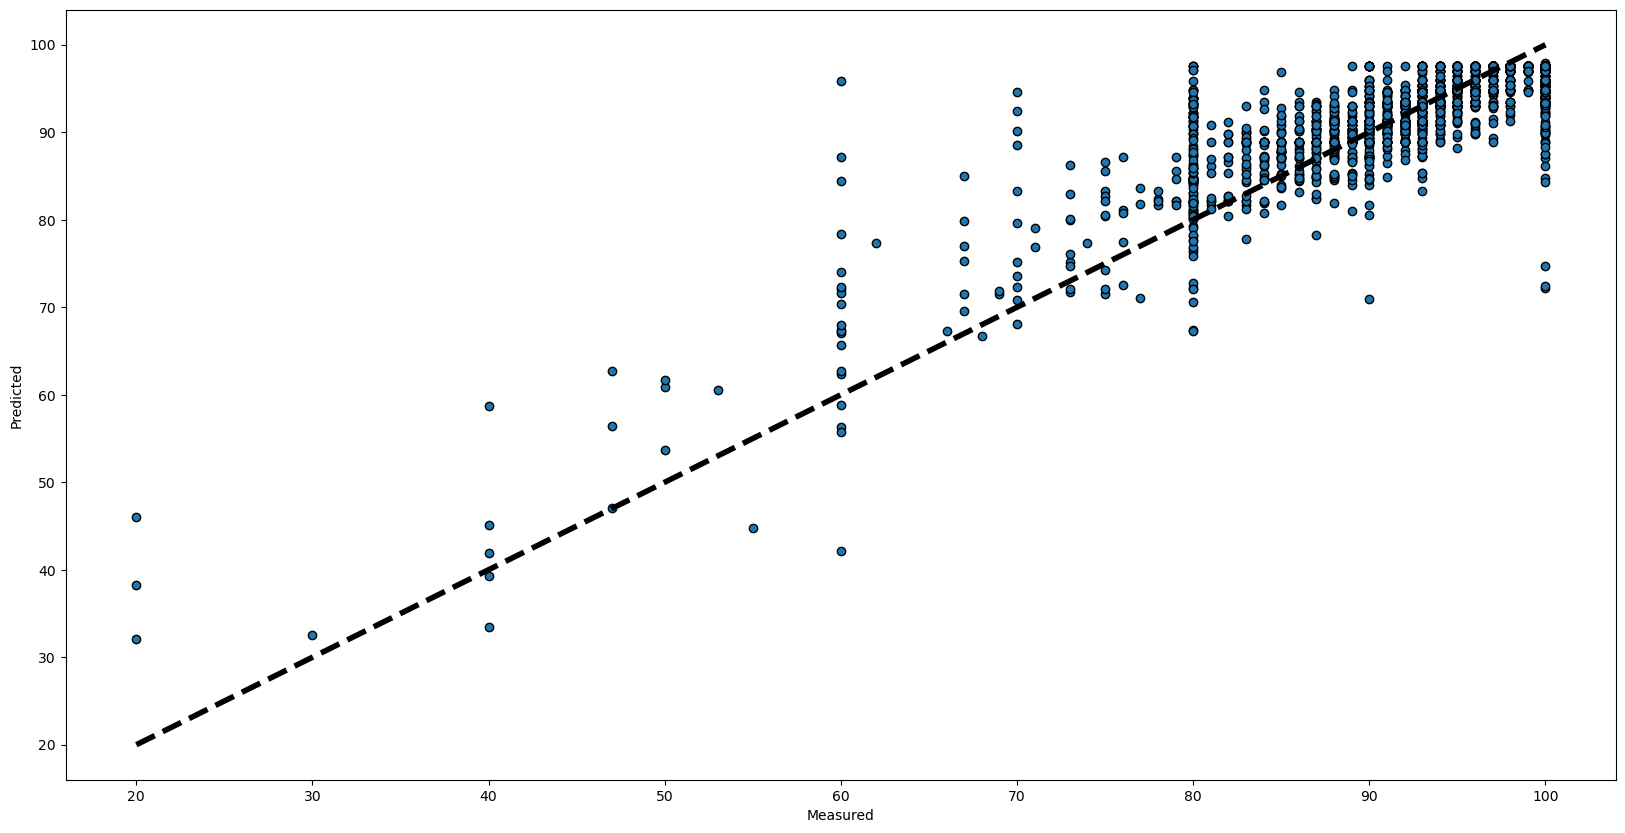

In [22]:
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
X_train_features = feature_extractor.predict(X_train_scaled)
X_test_features = feature_extractor.predict(X_test_scaled)


xgb = xgboost.XGBRegressor(objective ='reg:squarederror')

param_space = {
    'n_estimators': np.arange(1, 500, 10),
    'max_depth': np.arange(3, 11),
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2] 
}

random_search = RandomizedSearchCV(
estimator = xgb,
param_distributions = param_space,
cv = 5,
n_jobs= -2,
n_iter = 1000,
verbose = 0
)


random_search.fit(X_train_features, y_train)
best_model = random_search.best_estimator_

# Käytetään parhaita hyperparametrejä
predictions = best_model.predict(X_test_features)

# Tarkastellaan mallin toimivuutta
fig, ax = plt.subplots(figsize = (20,10))
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

mse = mean_squared_error(predictions, y_test)
mae = mean_absolute_error(predictions, y_test)

# Tallennetaan saadut arvot
models_performance = pd.concat([models_performance, pd.DataFrame({'Model Name': ['XGBoost with Neural Network Features'], 'MSE': [mse], 'MAE': [mae]})], ignore_index=True)






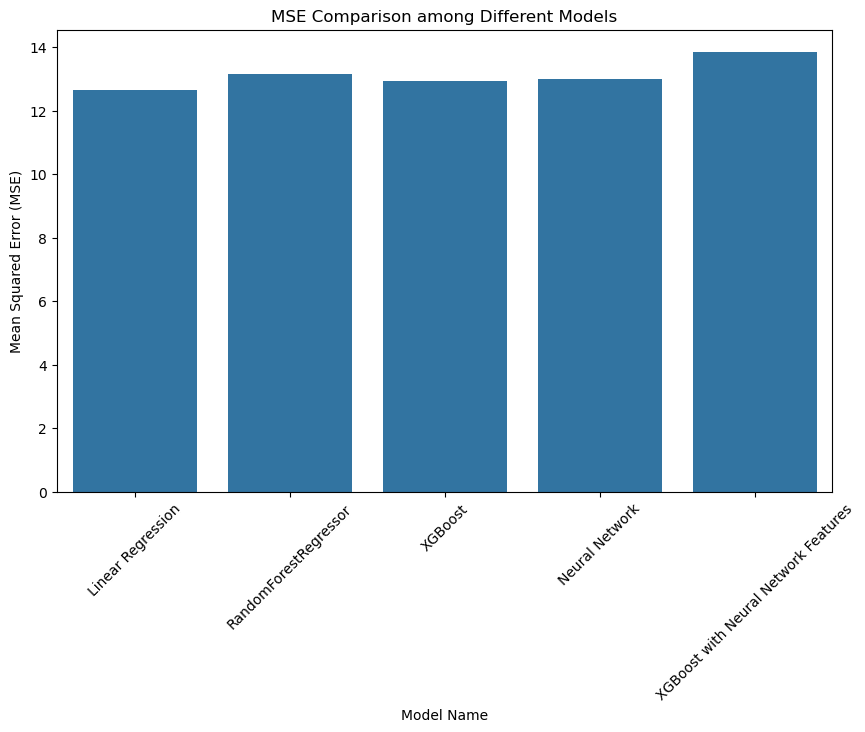

In [23]:
import seaborn as sns

# MSE:n visualisointi eri malleille
plt.figure(figsize=(10, 6))
sns.barplot(x='Model Name', y='MSE', data=models_performance)
plt.title('MSE Comparison among Different Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('Model Name')
plt.xticks(rotation=45)
plt.show()
